# Recommendation Systems: Amazon product reviews

The purpose is to work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
### Context: 
--------------

E-commerce websites like Amazon, Flipkart uses different recommendation models to provide personalized suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
### Objective:
----------------

Build a recommendation system to recommend products to customers based on their previous ratings for other products.

--------------
### Dataset:
--------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** Rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating (ignore this column for this exercise)

In [ ]:
# Use the following code to mount the drive if you use Google Colab for this project. It is not necessary to use Colab for this project.
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Install the surprise package in Google Colab in order to use the same
!pip install surprise
# conda install -c conda-forge scikit-surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)


### Import Libraries

In [ ]:
import warnings #Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

import matplotlib.pyplot as plt #Basic library for data visualization.
import seaborn as sns #Slightly advanced library for data visualization

# from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.
from collections import defaultdict #A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # A performance metrics in sklearn.

### Load data

In [ ]:
# Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence we can reduce the dataset by considering certain Logical assumptions.**

Here, We will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [ ]:
# Get the column containing the users
users = df.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [ ]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the users
users = df.prod_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
# If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
# Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considred
RATINGS_CUTOFF = 5
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = df.loc[~df.prod_id.isin(remove_users)]

In [ ]:
# see a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### Exploratory Data Analysis

**Fill in the blanks and complete the code(and provide observations) for the following cells wherever mentioned.**

#### Shape of the data

In [ ]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


**Obervations:**
* **Large dataset which needs to reduce the dataset** - Since there are 7.8M observations in the original dataset. It's really necessary to be reduced for better operation afterward.
* **Criteria helps** - With taking users who have given at least 50 ratings, and the products that have at least 5 ratings, we could reduce the rows to around 65K rows only according to the code above.
* **Three columns only** - In a simpler recommendation system model, there normally are 3 key factors. In this case, we have only user, product, and the rating - which are three columns only.

#### Data types

In [ ]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Obervations:**
* **Object data types** - The user_id and the prod_id two dat types are all objects which are not the numerial numbers to watch for the distributions.
* **flat64 data types** - The rating is the float645, which is pretty resonable normaly with one decimal.

#### Check for missing values

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Obervations:**
* **No missing values** - It's great to know there are no missing values by the isnull function. We may need to fill up something or to drop some rows if there are some missing values**

#### Summary Statistics

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Obervations:**
* **Describe function** - We use describe function to find out the summary statistics for "rating" variable.
* **Total around 65K observations** - It's a very important number we have which is around 65K ratings where the user rates the product.
* **Potential power law distribution** - The mean is 4.29 and the median and at 75% there are all 5.00. We doubt it could be a power law distribution that a lot of rating is in 5-star, and a long tail all the way from 4, 3, 2 to 1 star.**

#### Check the rating distribution

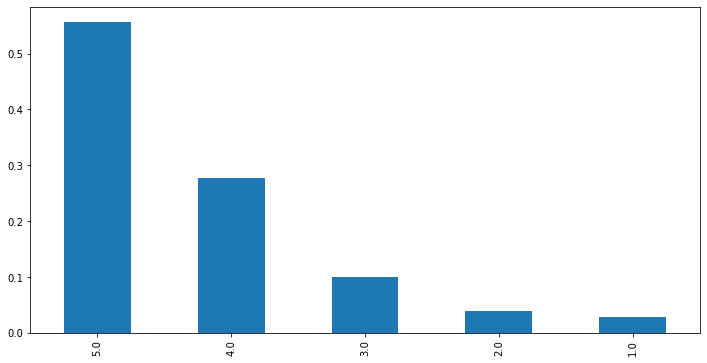

In [ ]:
# Create the bar plot and provide observations

plt.figure(figsize = (12,6))
df_final['rating'].value_counts(1).plot(kind= 'bar')
plt.show()

**Observations:**
* **1. Bar plot** - The best way to present is through bar plot since there are very few choices for people. We can visulilze the distribution easily by bar plot with value_counts function.
* **2. Power law distribution** - The doubt is confirmed by this bar plot that it's supposedly a power law distribution. We can easily visualize a huge counts in the 5-star then sharply/exponentially decrease as the count goes down to 1.

#### Check the number of unique users and items in the dataset

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


- There are **1540 unique users and 5689 products** in the dataset

#### Users with most number of ratings

In [ ]:
# Top 10 users based on rating
most_rated = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

### Data preparation

In [ ]:
# Check the number of unique USERS and PRODUCTS in the final data and provide observations

print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  5689


**Observations:**
* **Unique users 1.5K and unique products 5.7K** - We have the number of unique users and products in the final data are 1,540 and 5,689 each after criteria set to reduce the dataset.
* **The potential maximum observations we may have is around 8.8M** - If every unique user and unique products are all matching to get 1 rating, it's supposedly 8.8M around (8,761,060). Here we don't consider it too complicated if one user and one item may have multiple ratings. We just have a feeling that we're reducing the dataset to a very manageable degree for the prediction.
* **Current total observations we have is around 65K ratings, less than 1% for the potential universe** - In the previous observation about the rating variable, we have 65K around. In comparison to 8.8M or 7.8M. It's only a less than 1% portion. It means we really successfully made the data much simpler. 
* **Very sparse dataset to deal with** - It's a special dataset we have to deal with. Very sparse dataset that a certain portion of the users commented and a group of the products get ratings in a sparse fashion. We should find some great algorithms to overcome this data structure and complete the recommendation business goal we want. 


Now that we have explored and preprocessed the data, build the first recommendation system

### Rank Based Recommendation System

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
# Calculate the average rating for each product 
average_rating = df_final.groupby(by='prod_id').mean()['rating']
# Calculate the count of ratings for each product
count_rating = df_final.groupby(by ='prod_id').count()['rating']
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating', ascending = False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# define a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    # Find products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]
    
    # Sort values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

#### Recommending top 5 products with 50 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Recommending top 5 products with 100 minimum interactions based on popularity

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

Recommended the **top 5** products by using the popularity recommendation system. Build a recommendation system using collaborative filtering

### Collaborative Filtering Based Recommendation System

In this type of recommendation system, it does no need any information about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
 * User User Similarity Based  
 * Item Item similarity based
- Model based

#### Build a baseline user user similarity based recommendation system

- Below we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, import the necessary classes and functions from this library
- Please use the following code to `install the surprise` library. You don't need to run the following code if the surprise library is installed on your system.

**!pip install surprise**

In [ ]:
# Compute the accuracy of models
from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing KFold cross-validation
from surprise.model_selection import KFold

#For implementing clustering-based recommendation system
from surprise import CoClustering

#### Before building the recommendation systems, to go over some some basic terminologies to be used:

**Relevant item** - An item (product in this case) that is actually **rated higher than the threshold rating (here 3.5)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item** - An item that's **predicted rating is higher than the threshold (here 3.5) is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN)** - It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider** which they would like to minimize.

**False Positive (FP)** - It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider** which they would also like to minimize.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are the two most used performance metrics used in the assessment of recommendation systems.**

### Precision@k and Recall@ k

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-Score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### Some useful functions

- Below function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

In [ ]:
def precision_recall_at_k(model, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    # Make predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

Below we are loading the **`rating` dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
# instantiate Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# load the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# split the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

- Now we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**, it is used to find the **desired similar items among a given set of items**.

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 is taken for the recommended and relevant ratings**. 
- In the **present case precision and recall both need to be optimized as the service provider would like to minimize both the losses discussed** above. Hence, the correct performance measure is the **F_1 score**. 

### Build the user-user similarity-based recommendation system
- Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1
- Fit the model on the training data 
- Use the precision_recall_at_k function to calculate the metrics on the test data 
- Provide your observations on the output 

In [ ]:
# Declare the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:**
* **1. RMSE** - We have calculated RMSE to check how far the overall predicted ratings are from the actual ratings. It's 1.00. Normally we want the RMSE as small as possible. We will keep improving model to see if there's room to make RMSE smaller with a significant reduction.
* **2. Recall** - We are getting a recall of ~0.85, which means out of all the relevant product 85% are recommended.
* **3. Precision** - We are getting a precision of ~ 0.86, which means out of all the recommended product 86% are relevant.
* **4. f_1 score** - It is ~0.86. It indicates that mostly recommended movies were relevant and relevant products were recommended. 
* **5. Room to improve** - We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

**predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466'.

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
df_final[df_final.prod_id=="1400501466"].user_id.unique()

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY',
       'AW3LX47IHPFRL', 'A1E3OB6QMBKRYZ', 'A19N3S7CBSU6O7'], dtype=object)

* It can be observed from the **above list that user "A34BZM6S9L7QI4" has not seen a product with productId "1400501466"**.

Below it's **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not seen yet i.e. `prod_id=1400501466`** 

In [ ]:
#predicting rating for a sample user with a non interacted product.
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improving similarity-based recommendation system by tuning its hyper-parameters

Below it will be tuned hyperparameters for the `KNNBasic` algorithms. Try to understand some of the hyperparameters of KNNBasic algorithm

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# set up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# perform 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fit the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9713481893604904
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above

Build the **final model by using tuned values of the hyperparameters** which we received by using **grid search cross-validation**

In [ ]:
# use the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# create an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, random_state=1, verbose=False)

# train the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# compute precision@k and recall@k also with k =10.
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done compu

- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model is slightly better than the baseline model**. Along with this **the RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

- Predict rating for the user with `userId`="A3LDPF5FMB782Z", and `prod_id`= 1400501466 using the optimized model
- Predict rating for the same userId="A34BZM6S9L7QI4" but for a product which this user has not interacted before i.e. prod_id = 1400501466, by using the optimized model
- Compare the output with the output from the baseline model

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui= 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
* **1. Known-rating user prediction improvement** - For the user ID "A3LDPF5FMB782Z" (Who has a rating of 5.00 already) the rating prediction improves from 3.40 to 4.29 (from baseline model to optimized model) - which is much closer to the 5.00 rating of this user for the product ID 1400501466'. We believe the optimized model after the grid search really works well!
* **2. User-without-rating prediction non-change** - For the user ID "A34BZM6S9L7QI4" (Who does not rate the product yet) the rating prediction does not change and keep it as 4.29 (from baseline model to optimized model) - It seems the optimized model improves the user who has the prediction very well but has the same result for the user who has not rated yet.

## Identifying similar users to a given user (nearest neighbors)

Find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric

In [ ]:
sim_user_user_optimized.get_neighbors(0,5) #Here 0 is the inner id of the above user.

[6, 7, 17, 26, 32]

#### Implement the recommendation algorithm based on optimized KNNBasic model

Below we will be implementing a function where the input parameters are - 

- data: a **rating** dataset
- user_id: a user id **against which we want the recommendations**
- top_n: the **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # create an empty list to store the recommended product ids
    recommendations = []
    
    # create an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')
    
    # extract those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # loop through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predict the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # append the predicted ratings
        recommendations.append((item_id, est))

    # sort the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

#### Predict top 5 products for userId="A3LDPF5FMB782Z" with similarity based recommendation system

In [ ]:
# Make top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
# Build the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### Correct the Ratings and Ranking the above products

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**. Along with the rating the **number of users who have seen that product** also becomes important to consider. Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly higher the **"rating_count" of a product more it is liked by users**. To interpret the above concept, a **product rated 4 with rating_count 3 is less liked in comparison to a product rated 3 with a rating count of 50**. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [ ]:
def ranking_products(recommendations, final_rating):
  # sort the products based on ratings count
  ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # merge with the recommended products to get predicted ratings
  ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # rank the products based on corrected ratings
  ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

  # sort the products based on corrected ratings
  ranked_products = ranked_products.sort_values('corrected_ratings', ascending=False)
  
  return ranked_products

**Note:** In the **above-corrected rating formula**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some products with ratings 5 and **we can't have a rating more than 5 for a product**.

In [ ]:
# Apply the ranking products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


### Item Item Similarity-based collaborative filtering recommendation systems 

* Above it's been seen **similarity-based collaborative filtering** where similarity has seen **between users**. Now look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [ ]:
# Declare the similarity options.
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items.
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving a good F_1 score of ~84%. We will try to **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm.

**predict a rating for a user with `userId=A3LDPF5FMB782Z` and `prod_Id=1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
#predicting rating for a sample user with an interacted product.
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

Below we are **predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted yet i.e. `prod_id=1400501466`** 

In [ ]:
# predict rating for a sample user with a non interacted product.
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Improve similarity-based recommendation system by tuning its hyper-parameters

Below it would be **tuned hyperparameters for the `KNNBasic` algorithms**. try to understand **some of the hyperparameters** of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

### Hyperparameter tuning the item-item similarity-based model
- Use the following values for the param_grid and tune the model
  - 'k':[10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# set up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k' : [3, 6, 9], 
              'sim_options' : {'name': ['msd', 'cosine'],
                                'user_based' : [False]}
              }

# perform 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fit the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix.

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation

### Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.

In [ ]:
# use the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# create an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options , k = 30, min_k = 6 , random_state=1, verbose=True)

# train the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Compute precision@k and recall@k, f1_score@k and RMSE
precision_recall_at_k(sim_item_item)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Observations:**
* **1. What we have in this new model** - We use the item-item similarity (instead of user-user) and the newly grid serach again to get the new parameters (k = 30, min_k= 6, sim_options name = msd, simp_options user_based = False)
* **2. Comparing all the results** - We have very results to see from different angles (user-user vs item-item)
 * **1) RMSE (~ 0.95 vs ~1.00)** - Item-item model has a better result with ~5% gap. 
 * **2) Recall (~0.89 vs ~0.85)** - User-user model has a better result with ~4% gap.
 * **3) Precision (~0.85 vs ~0.84)** - Two models almost have a similar result.
 * **4) f1-score (~0.87 vs ~0.84)** - Item-item model has a slightly better result with ~3% gap. 
* **3. Conclusion** - We won't exactly judge which model is better. From the recall viewpoint to have a better prediction to make sure we won't lose the chance to recommend to users, we may pick User-user. If we prefer smaller RMSE and f1-score to choose the performance, it's the Item-item model's better. However, both models all perform pretty well.

predict **rating for an user with `userId=A3LDPF5FMB782Z` and for `prod_id=1400501466`** with the **optimized model** as shown below

In [ ]:
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

Below we are **predicting rating** for the same **`userId=A34BZM6S9L7QI4`** but for a product which this user **has not interacted before** i.e. `prod_id==1400501466`, by using the optimized model as shown below - 

In [ ]:
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

#### Identify similar users to a given user (nearest neighbors)

find out **similar users** to a given user or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding 5 most similar users to the user with internal id 0 based on the `msd` distance metric

In [ ]:
sim_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

#### Predict top 5 products for userId="A1A5KUIIIHFF4U" with similarity based recommendation system

In [ ]:
# Make top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Build the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [ ]:
# Apply the ranking products function and sorting it based on corrected ratings. 
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


* It has been seen **similarity-based collaborative filtering algorithms**, get into **model-based collaborative filtering algorithms**.

### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

#### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

### Build the matrix factorization recommendation system (using random_state=1) and provide your observations on performance of the model

In [ ]:
# use SVD matrix factorization
svd = SVD(random_state = 1)

# train the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations:**
* **1. What we have in this new model** - We use the SVD matrix factorization.
* **2. Comparing all the results** - We have results to see from different angles (user-user vs item-item vs SVD)
 * **1) RMSE (~ 0.95 vs ~1.00 vs ~0.89)** - Item-item model has a better result than other 2 models with ~5 to 6% gap.
 * **2) Recall (~0.89 vs ~0.85 vs ~0.85)** - User-user model has a better result than other 2 models with ~4% gap.
 * **3) Precision (~0.85 vs ~0.84 vs ~0.89)** - SVD model has a better result than the other 2 models with a ~4 to 5% gap.
 * **4) f1-score (~0.87 vs ~0.84 vs ~0.87)** - Item-item model and SVD have a slightly better result than user-user with ~3% gap.
* **3. Conclusion** - We won't exactly judge which model is better. From the recall viewpoint to have a better prediction to make sure we won't lose the chance to recommend to users, we may pick User-user. If we prefer a smaller RMSE and f1-score to choose the performance, its Item-item model's better. SVD works the best from the precision viewpoint. However, the three models all perform pretty well.**

 predict the rating for a user with `userId="A3LDPF5FMB782Z"` and `prod_id="1400501466` as shown below
- Here the user has already rated the product.

In [ ]:
# Make prediction.
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Below we are predicting rating for the same `userId=A34BZM6S9L7QI4` but for a product which this user has not interacted before i.e. `productId=1400501466`, as shown below - 

In [ ]:
# Make prediction. 
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

#### Improve matrix factorization based recommendation system by tuning its hyper-parameters

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [ ]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# perform 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fit data
gs_.fit(data)

# best RMSE score
print(gs_.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8986313197175769
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters as shown above

Now we will **the build final model** by using **tuned values** of the hyperparameters which we received by using grid search cross-validation

### Fit the SVD model using the hyperparameters from GridSearchCV (use random_state=1) and compare the output with the baseline model

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 20, lr_all = .01, reg_all = .2, random_state = 1 )

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score@k, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Observations:**
RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866**

predict a rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466` with the optimized model as shown below

Using the optimized svd model, predict rating for the user with `userId`="A3LDPF5FMB782Z", and `prod_id`= 1400501466 
- Predict rating for the same userId="A34BZM6S9L7QI4" but for a product which this user has not interacted before i.e. prod_id = 1400501466, by using the optimized model 
- Compare the output with the output from the baseline model 

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466.
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", r_ui = 5, verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.216280997100113, details={'was_impossible': False})

**Observations:**
* **Rating predicted change for userId "A3LDPF5FMB782Z"** - The rating predicted in the optimized model increases but not much from 4.08 to 4.13.
* **Rating predicted change for userId "A34BZM6S9L7QI4"** - The rating predicted in the optimized model decreases but not much from 4.40 to 4.22.
* **Room to finetuned** - Those two users never rates this product yet. We compare the optimized model frmo the baseline model. Though 0.05 or 0.18 gap won't change a rating from 4 to 4.5 or 4 to 3.5, but we trust the finetuning after the grid search because once our business decision finetunes to the 1st digit decimal, it may have influences.

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


- Get 5 recommendations for the user with user_id = 'A2XIOXRRYX0KZY' using the svd_optimized model. Hint: Use get_recommendations() function
- Rank the recommendations  on the basis of the correct ratings. Hint: Use ranking_products() function 

In [ ]:
# Get top 5 recommendations for user_id A2XIOXRRYX0KZY using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, "A2XIOXRRYX0KZY", 5, svd_optimized)

In [ ]:
# Rank products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00IVPU6AA,14,4.851976,4.584715
2,B000JV9LUK,10,4.888310,4.572082
1,B0010Y414Q,11,4.860932,4.559421
3,B00AR95ESC,9,4.858811,4.525478
4,B005PQTYHE,7,4.842736,4.464772


**Conclusion:**
* **1, We use 4 distinct algorithms to build recommendation systems** - They are as follows:
  - **Rank-based**  - using averages
  - **User-user-similarity-based** - collaborative filtering
  - **Item-item-similarity-based** - collaborative filtering
  - **Model-based** - (matrix factorization) collaborative filtering - We use SVD algorithm.

* **2. "Surprise" (library) is needed** - To demonstrate "user-user-similarity-based collaborative filtering", "item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering", surprise, an easy-to-use Python library that allows us to quickly build rating-based recommender systems without reinventing the wheel really surprises us! In Jupyter, we have to pre-install from Anaconda to make it work.
* **3. SVD is useful** - "Surprise" also gives us access to the matrix factors when using models such as SVD, which allows us to visualize the similarities between the items in our dataset library has been demonstrated. 

* **4. Grid search cross-validation** - It is used to find the optimal hyperparameters for the data. Hyperparameter tuning is an important technique from here.

* **5. Precision@k and recall@k** - Using these two metrics helps for performance evaluation. The F_1 score is calculated for each working model. Overall, the user-user similarity-based recommendation system has given the best performance in terms of the F1-Score.

* **6. Hybrid recommendation systems potential** - We can also combine different recommendation techniques to build hybrid recommendation systems.

* **7. Final conclusion - no specific model is the best** - In machine learning, we try to explore a great portfolio of algorithms to try various datasets and business goals. It looks like we can't clearly judge which model works the best for the recommendation predictions according to the results above.